# IMPORT LIBRARY

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
import time
import cv2
import pathlib
import matplotlib as mpl

C:\Users\OIC-OPS\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\OIC-OPS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\OIC-OPS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
img_width = 448
img_height = 448
batch_size = 64
color = 3
path = 'D:\OFA AI Mastery\projek akhir'
path_extract = os.path.join(path, "kurma.zip")

#INSTALL DATASET USED IN OUR PROJECT

In [12]:
import zipfile
with zipfile.ZipFile(path_extract,"r") as z:
    z.extractall(".")

#SHOW DATASET IMAGES

In [3]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir('train data/'):
    nums.append(len(os.listdir('train data/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,Ajwa,175
1,Galaxy,190
2,Medjool,135
3,Meneifi,232
4,Nabtat Ali,177
5,Rutab,146
6,Shaishe,171
7,Sokari,264
8,Sugaey,168


<Axes: xlabel='Name of class', ylabel='Number of samples'>

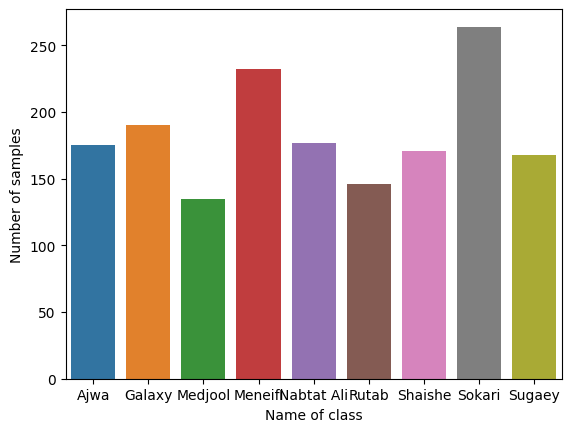

In [4]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

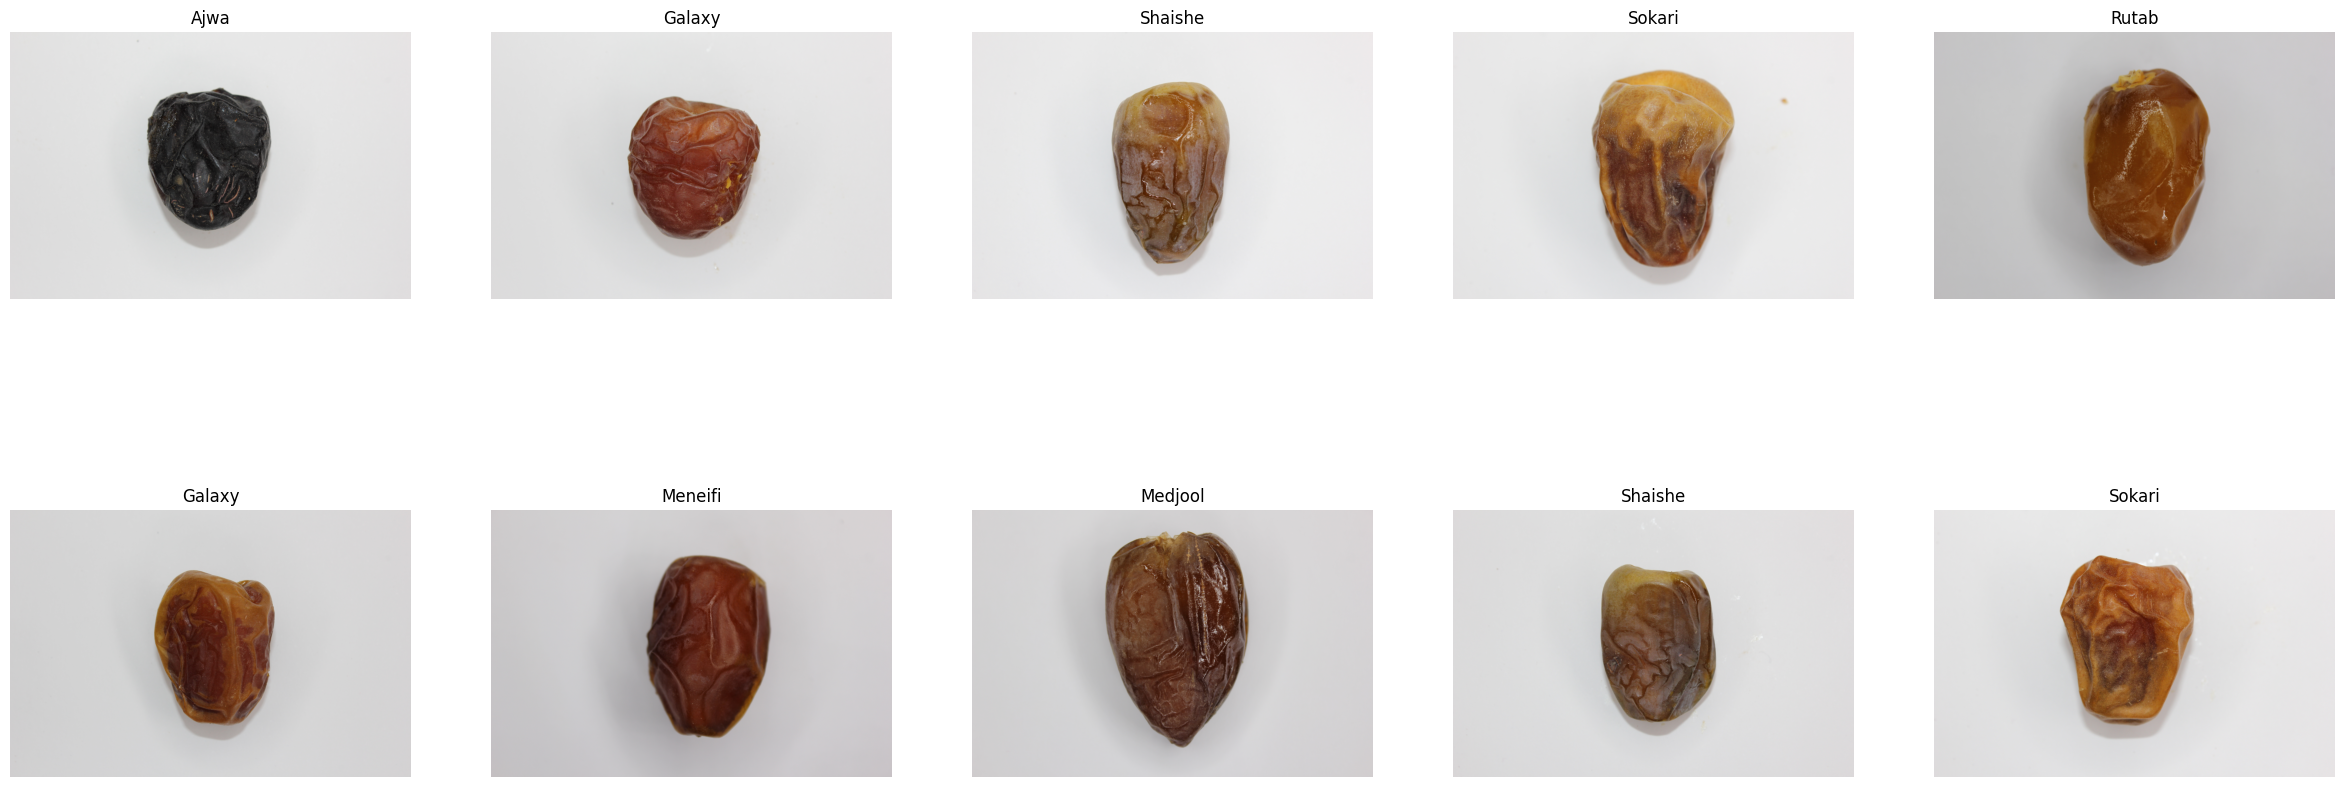

In [5]:
classes = os.listdir('train data/')

plt.figure(figsize=(30 , 30))
for x in range(10):
    i = random.randint(0,7)                    # getting the class
    images = os.listdir('train data'+'/'+classes[i])
    j = random.randint(0,100)                  # getting the image
    image = cv2.imread('train data'+'/'+classes[i]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[i])
    plt.axis("off")

plt.show()

In [6]:
def Blurring(image):
  image = cv2.medianBlur(image,5)
  return image
def image_generator(data):
  datagen = ImageDataGenerator( rescale=1/255, validation_split=0.1,vertical_flip=True ,horizontal_flip=True,width_shift_range=0.2,height_shift_range=0.2,
                               rotation_range = 5, shear_range = 0.02,zoom_range = 0.02, preprocessing_function = Blurring)
  train_generator = datagen.flow_from_directory(
      'train data/',
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      shuffle=True,
      subset='training')
  validation_generator = datagen.flow_from_directory(
      'train data/', 
      target_size=(img_height, img_width),
      batch_size= batch_size,
      shuffle=False,
      class_mode='categorical',
      subset='validation') 
  return [train_generator, validation_generator]

In [7]:
[training_dataset, validation_dataset] = image_generator(data)

Found 1496 images belonging to 9 classes.
Found 162 images belonging to 9 classes.


#Transfer Learning using mobilenet_v2

In [8]:
mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, color))
model = keras.layers.Dropout(0.2)(mobilenetv2.output)
model = keras.layers.Flatten()(model)
model = keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(128, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(64, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(32, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.layers.Dropout(0.2)(model)
model = keras.layers.Dense(16, activation='relu',  kernel_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.layers.Dropout(0.2)(model)
prediksi = keras.layers.Dense(len(classes), activation='softmax', activity_regularizer=tf.keras.regularizers.L2(0.01))(model)
model = keras.models.Model(inputs=mobilenetv2.input, outputs=prediksi)
for layer in model.layers[:151]:
    layer.trainable = False
for layer in model.layers[151:]:
    layer.trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 224, 224, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 224, 224, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [9]:
len(model.layers)

167

In [10]:
model.layers[151:]

In [11]:
metric = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
]

In [14]:
base_learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=base_learning_rate),
              loss="categorical_crossentropy",
              metrics=metric)

In [15]:
epochs=100
history = model.fit(
  training_dataset,
  epochs=epochs,
  batch_size = batch_size
)

Epoch 1/100
24/24 [==============================] - 356s 14s/step - loss: 125.6517 - tp: 61.0000 - fp: 348.0000 - tn: 11620.0000 - fn: 1435.0000 - accuracy: 0.8676 - precision: 0.1491 - recall: 0.0408 - auc: 0.5192
Epoch 2/100
24/24 [==============================] - 361s 15s/step - loss: 58.4018 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 11968.0000 - fn: 1496.0000 - accuracy: 0.8889 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5361
Epoch 3/100
24/24 [==============================] - 340s 14s/step - loss: 26.9923 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 11968.0000 - fn: 1496.0000 - accuracy: 0.8889 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5492
Epoch 4/100
24/24 [==============================] - 342s 15s/step - loss: 15.4730 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 11968.0000 - fn: 1496.0000 - accuracy: 0.8889 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5739
Epoch 5/100
24/24 [==============================] - 323s 13s/step - loss: 10.4421 - tp: 7.0000 - fp

# Metrics

In [18]:
def kurva(p1, p2, p3, p4):
  a = p1[0]
  b = p2[0]
  c = p3[0]
  d = p4[0]
  plt.figure(figsize = (20,4))
  plt.plot(a,'blue', label=p1[1])
  plt.plot(b,'orange', label=p2[1])
  plt.plot(c,'red', label=p3[1])
  plt.plot(d,'green', label=p4[1])
  plt.legend()

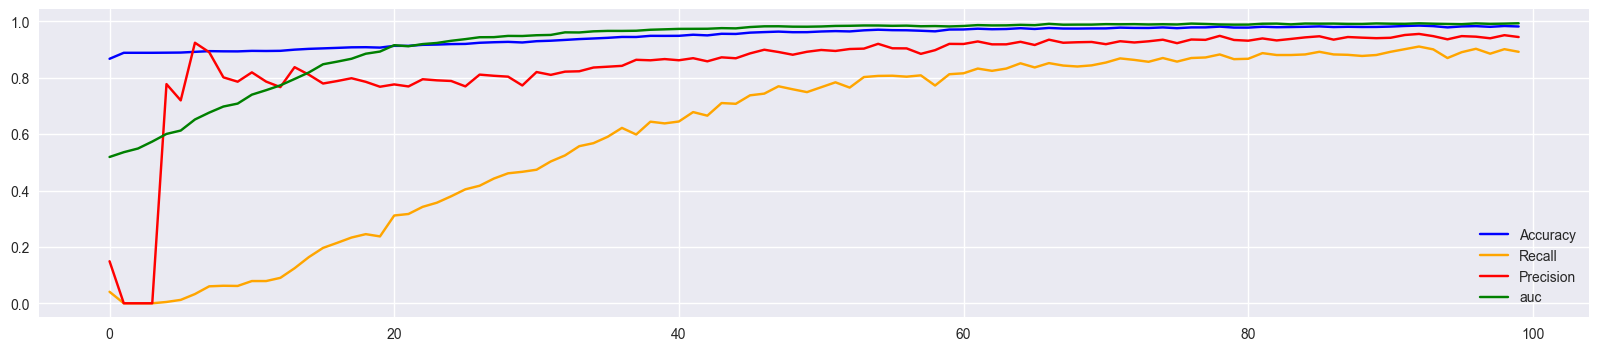

In [19]:
kurva(
    [history.history['accuracy'], 'Accuracy'],
    [history.history['recall'], 'Recall'],
    [history.history['precision'], 'Precision'],
    [history.history['auc'], 'auc']
)

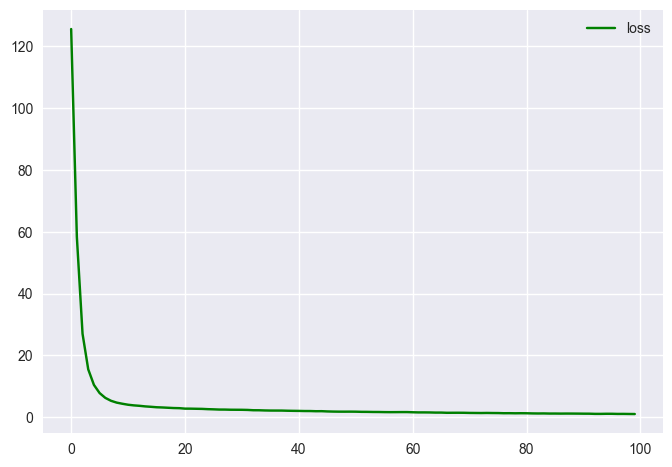

In [20]:
plt.plot(history.history['loss'],'green', label="loss")
plt.legend()

In [21]:
model.evaluate(validation_dataset,batch_size = validation_dataset.batch_size ,steps = validation_dataset.n // validation_dataset.batch_size)

2/2 [==============================] - 43s 17s/step - loss: 0.8411 - tp: 124.0000 - fp: 2.0000 - tn: 1022.0000 - fn: 4.0000 - accuracy: 0.9948 - precision: 0.9841 - recall: 0.9688 - auc: 0.9989


[0.8410707116127014,
 124.0,
 2.0,
 1022.0,
 4.0,
 0.9947916865348816,
 0.9841269850730896,
 0.96875,
 0.9988746643066406]

In [22]:
validation_dataset.reset()

In [23]:
Y_pred = model.predict(validation_dataset,  workers=1)

3/3 [==============================] - 36s 10s/step


In [24]:
y_pred = np.argmax(Y_pred ,  axis = 1)

In [25]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4,
       4, 5, 5, 5, 5, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 6, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8], dtype=int64)

In [26]:
validation_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8])

In [27]:
len(y_pred)

162

In [28]:
len(validation_dataset.classes)

162

In [29]:
res = tf.math.confusion_matrix(y_pred,validation_dataset.classes).numpy()

In [31]:
confusion_matrix = pd.DataFrame(res,
                     index = classes, 
                     columns = classes)

In [32]:
confusion_matrix

,Ajwa,Galaxy,Medjool,Meneifi,Nabtat Ali,Rutab,Shaishe,Sokari,Sugaey
Ajwa,17,0,0,0,0,0,0,0,0
Galaxy,0,18,0,0,0,0,0,0,0
Medjool,0,0,13,0,0,0,1,0,0
Meneifi,0,0,0,23,0,0,0,1,0
Nabtat Ali,0,0,0,0,16,0,0,0,0
Rutab,0,0,0,0,1,13,0,0,0
Shaishe,0,0,0,0,0,0,15,0,1
Sokari,0,1,0,0,0,0,1,25,0
Sugaey,0,0,0,0,0,1,0,0,15


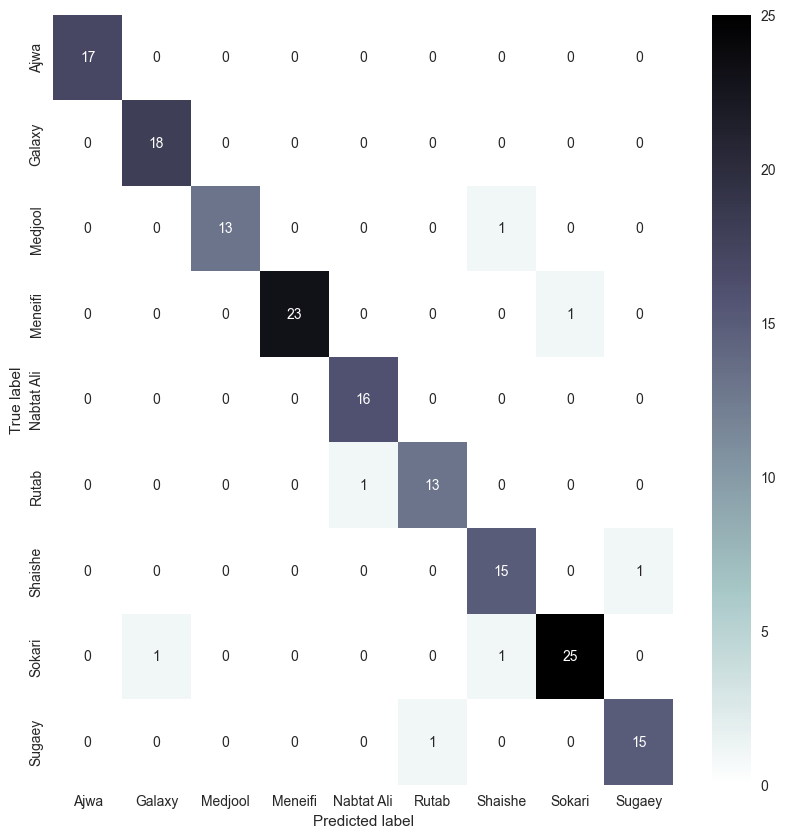

In [33]:
import seaborn as sns
figure = plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, cmap=plt.cm.bone_r)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [34]:
classification_report = classification_report(validation_dataset.classes, y_pred,target_names = classes)
print(classification_report)

              precision    recall  f1-score   support

        Ajwa       1.00      1.00      1.00        17
      Galaxy       1.00      0.95      0.97        19
     Medjool       0.93      1.00      0.96        13
     Meneifi       0.96      1.00      0.98        23
  Nabtat Ali       1.00      0.94      0.97        17
       Rutab       0.93      0.93      0.93        14
     Shaishe       0.94      0.88      0.91        17
      Sokari       0.93      0.96      0.94        26
      Sugaey       0.94      0.94      0.94        16

    accuracy                           0.96       162
   macro avg       0.96      0.96      0.96       162
weighted avg       0.96      0.96      0.96       162



In [35]:
model.save_weights("model_kurma.h5")